# Basic Doppler analysis: measuring the velocity of a particle using ultrasonic pulse-echo sequence

Assumptions and framework of the model:
- The particle is moving at constant velocity  
- This is a continuous wave (CW) analysis; we use long bursts for the pulse and echo signals, resulting in a high frequency resolution but the spatial resolution is poor.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
from scipy import signal
import ipywidgets

In [2]:
#   General
_2PI_ = 2.0*np.pi
#   Medium
c = 1500.0              # [m/s] speed of sound
Z = 1.5e6;              # [Ray.] mechanical impedance
#   System   
Fs = 50.0e6             # [Hz] sampling frequency
#   Carrier wave
T = 5.0e-3              # [sec] pulse length / ferquency resolution = 1/T = 200 Hz
F = 6.0e6               # [Hz] pulse freq
wavelength = c/F
K = _2PI_/wavelength    # [rad./m] wave number
phase_carrier = 0.0             # [Rad.] pulse phase
#   Particle / HIFU wave
#D = 0.1e-6              # [m] displacement amplitude
#Fparticle = 1.0e6       # [Hz] particle oscillation freq
# phase_particle = 0.0     # [Rad.] particle phase
#sc = 1.0                # scattering coefficient
#Uparticle = _2PI_*Fparticle*D
# << you can change these values and check the effect on the echo! >>
U_particle = +1.0          # [m/s] constant velocity of particle
X0_particle = 0.1         # [m] position of particle at t=0 this value converts to a constant phase and probably meaningless...
W = 0.8                  # scattering coefficient
# Noise
noise_amplitude = 0.0
noise_mean = 0.0
noise_sigma = 1.0
#   More...
t = np.arange(0, T, 1/Fs)
X_particle = X0_particle + U_particle * t # [m] particle (scatterer moves in a constant velocity parallel to the beam / theta=0)
N = t.size              # length of signal
N2 = int(np.ceil(N/2))  # half length
freqs = fft.fftfreq(N, 1/Fs)[:N2]    # Fourier frequencies
#freqs[-1]               # check - the last term should be Nyquist (25MHz?)

In [3]:
global pulse, pulse_, echo, echo_

In [4]:
# Pulse & Echo signals
def my_signals(t=t, k=K, f=F, phase=phase_carrier, x0=X0_particle, u=U_particle, na=noise_amplitude, w=W):
    global pulse, pulse_, echo, echo_
    x = x0 + u*t
    pulse = np.sin(_2PI_*f*t + phase)
    echo = w*np.sin(_2PI_*f*t + phase + 2*k*x) # Doppler shift = 2 (u/c) F, the factor 2 is for round trip
    if noise_amplitude != 0:
        noise = na*np.random.normal(noise_mean, noise_sigma, N)
        echo = echo + noise
    # Fourier transform     
    pulse_ = fft.fft(pulse)[:N2]
    echo_ = fft.fft(echo)[:N2]
    echo_max = np.abs(echo_).argmax()

In [5]:
def my_plot(echo, pulse, start, window):
    #plt.plot(t*1e3, signal, label = 'signal')
    #plt.xlim([t1, t1 + w1])
    handle = plt.plot(t*1e6, pulse, t*1e6, echo)
    plt.xlim([start, start + window])
    plt.legend(['pulse', 'echo'])
    plt.title('Scatterer moves at a constant velocity - time domain')
    plt.grid()
    plt.xlabel('[uSec.]')
    return handle

In [6]:
def create_plot(start, window, t=t, k=K, f=F, phase=phase_carrier, x0=X0_particle, u=U_particle, na=noise_amplitude, w=W):
    global pulse, echo
    my_signals(t, k, f, phase, x0, u, na, w)
    return my_plot(start, window, pulse, echo)

In [7]:
ipywidgets.interact_manual(create_plot, start = (0, 4900, 69.25), window = (0.0, 10, 1), U_particle = (-1.0, 1, 0.1))

interactive(children=(FloatSlider(value=2423.75, description='start', max=4900.0, step=69.25), FloatSlider(val…

<function __main__.create_plot(start, window, t=array([0.00000e+00, 2.00000e-08, 4.00000e-08, ..., 4.99994e-03,
       4.99996e-03, 4.99998e-03]), k=25132.741228718343, f=6000000.0, phase=0.0, x0=0.1, u=1.0, na=0.0, w=0.8)>

In [ ]:
#pulse_ = fft.fft(pulse)[:N2]
#echo_ = fft.fft(echo)[:N2]
echo_max = np.abs(echo_).argmax()
print(echo_max)

In [ ]:
def my_FFTPLot(freqs, pulse_, echo_, window = 0.12):
    h1 = plt.subplot(2,1,1)
    plt.plot(freqs/1e6, np.log(np.abs(pulse_)), label = 'pulse')
    plt.plot(freqs/1e6, np.log(np.abs(echo_)), label = 'echo')
    plt.grid()
    plt.legend()
#plt.xlabel('[MHz]')
    plt.title('The spectrum of the pulse and the echo (Doppler shifted)')
#
    h2 = plt.subplot(2,1,2)
    plt.plot(freqs/1e6, np.log(np.abs(pulse_)), label = 'pulse')
    plt.plot(freqs/1e6, np.log(np.abs(echo_)), label = 'echo')
    plt.grid()
    plt.legend()
    plt.xlabel('[MHz]')
    window = window
    start = freqs[echo_max]/1e6 - window/2
    stop = freqs[echo_max]/1e6 + window/2
    plt.xlim([start, stop])
    return [h1, h2]


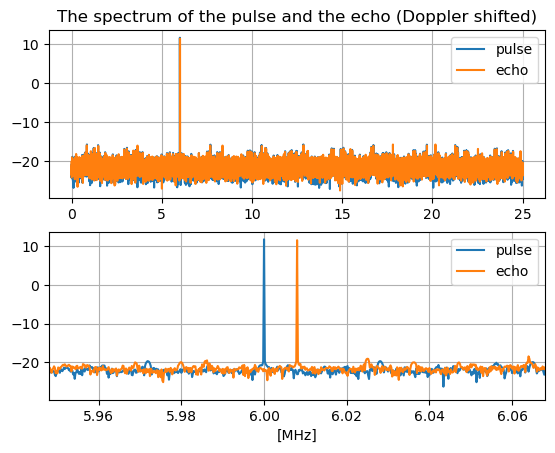

In [ ]:
h1, h2 = my_FFTPLot(freqs, pulse_, echo_)

In [ ]:
h2

<Axes: xlabel='[MHz]'>

In [ ]:
ipywidgets.interact_manual(my_FFTPLot, window = (0, 0.24, 0.01))

interactive(children=(FloatSlider(value=0.12, description='window', max=0.24, step=0.01), Button(description='…

<function __main__.my_FFTPLot(window=0.12)>

In [ ]:
# Standard processing
#
# Demodulation - extracting the difference in frequency (shift):
demod = pulse*echo
# Filter
b, a = signal.butter(5, 20e+3, fs=Fs, btype = 'low', analog = False)
demodf = signal.lfilter(b, a, demod)
# Fourier
demod_ = fft.fft(demod)[:N2]
demodf_ = fft.fft(demodf)[:N2]

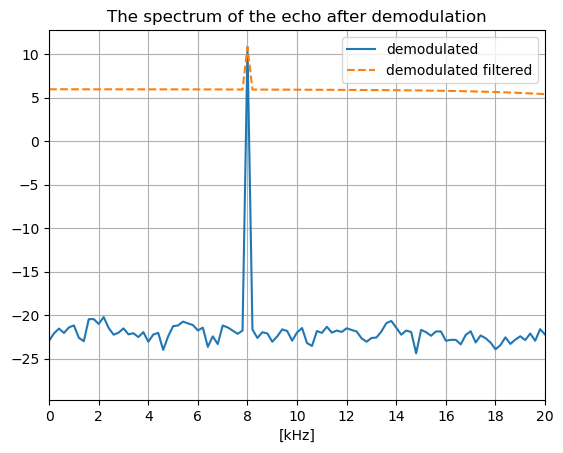

In [ ]:
plt.plot(freqs/1e3, np.log(np.abs(demod_)), label = 'demodulated')
plt.plot(freqs/1e3, np.log(np.abs(demodf_)), '--', label = 'demodulated filtered')
plt.grid()
plt.title('The spectrum of the echo after demodulation')
plt.xlabel('[kHz]')
plt.legend()
plt.xlim([0, 20])
plt.xticks(np.arange(0,22,2));

In [ ]:
# I-Q demodulation (Quadrature)
I = np.sin(_2PI_*F*t) * echo
Q = np.cos(_2PI_*F*t) * echo
#IQ = np.array(I*I + Q*Q)
#iqdemod = np.sqrt(I*I + Q*Q)
# Filter
b, a = signal.butter(5, 50e+3, fs=Fs, btype = 'low', analog = False)
#iqdemodf = signal.lfilter(b, a, iqdemod)
Ifiltered = signal.lfilter(b, a, I)
Qfiltered = signal.lfilter(b, a, Q)
# Fourier
#iqdemod_ = fft.fft(iqdemod)[:N2]
#iqdemodf_ = fft.fft(iqdemodf)[:N2]
I_ = fft.fft(I)[:N2]
Q_ = fft.fft(Q)[:N2]
Ifiltered_ = fft.fft(Ifiltered)[:N2]
Qfiltered_ = fft.fft(Qfiltered)[:N2]

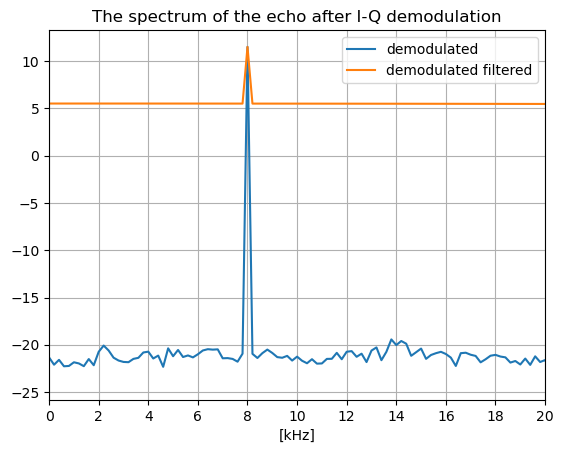

In [ ]:
plt.plot(freqs/1e3, np.log(np.abs(I_) + np.abs(Q_)), label = 'demodulated')
plt.plot(freqs/1e3, np.log(np.abs(Ifiltered_) + np.abs(Qfiltered_)), label = 'demodulated filtered')
plt.grid()
plt.title('The spectrum of the echo after I-Q demodulation')
plt.xlabel('[kHz]')
plt.legend()
plt.xlim([0, 20])
plt.xticks(np.arange(0,22,2));

In [ ]:
len(iqdemod)

250000

In [ ]:
F/1e6

6.0

(1050.0, 1052.0)

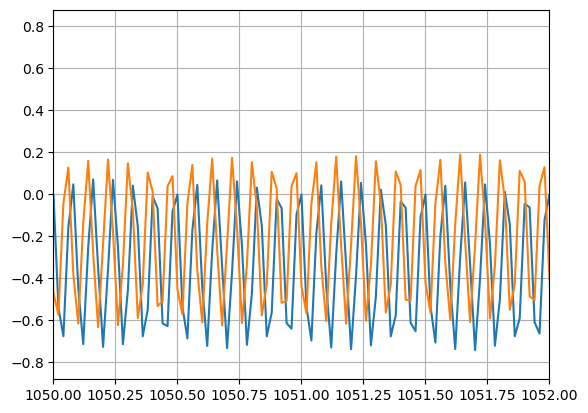

In [ ]:
t1 = 1050
d = 2
plt.plot(t*1e6, I, t*1e6, Q)
plt.grid()
plt.xlim([t1, t1 + d])

In [ ]:
len(t)

250000

In [ ]:
len(I)

250000

In [ ]:
len(Q)

250000

In [ ]:
ph = np.arctan2(Q, I)

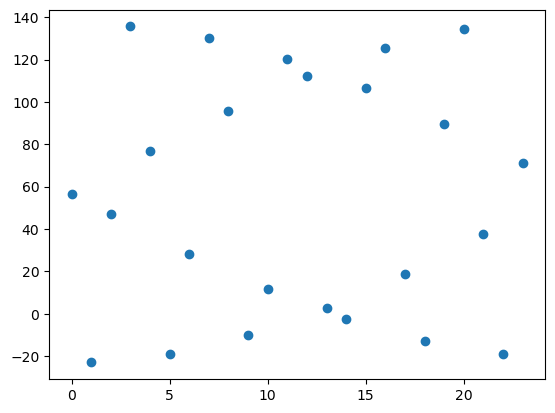

In [ ]:
i1 = 100000
w1 = 1000
S1 = []
for shift in range(24):
    S1.append(sum(I[i1:i1+w1] * Q[i1+shift:i1+w1+shift]))
plt.scatter(range(24), S1)

In [ ]:
Q.sum()

-4.3303316488163546e-10

In [ ]:
echo_max

29960

In [ ]:
echo_[echo_max]

(-3.127375355362817e-08-100000.00000000029j)

In [ ]:
freqs[echo_max]

6008000.0